In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('Taz_Water.csv')

# Unnessary Columns for preditive model

In [3]:
pred_uncol = ['date_recorded','funder','installer','longitude','latitude','wpt_name','num_private','subvillage'
              ,'recorded_by','scheme_name','ward','public_meeting',
             'extraction_type','payment','quality_group','source_type','quantity',
             'waterpoint_type_group','permit']

In [4]:
pred_df = df.drop(pred_uncol,axis=1)
pred_df.head()

,id,amount_tsh,gps_height,basin,region,region_code,district_code,lga,population,scheme_management,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,status_group
0,69572,6000.0,1390,Lake Nyasa,Iringa,11,5,Ludewa,109,VWC,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,1399,Lake Victoria,Mara,20,2,Serengeti,280,Other,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,686,Pangani,Manyara,21,4,Simanjiro,250,VWC,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,58,VWC,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,0,Lake Victoria,Kagera,18,1,Karagwe,0,NaN,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Setting target to binary

In [5]:
pred_df['status_group'] = pred_df['status_group'].replace('functional needs repair','functional')

In [6]:
dd = pred_df.drop('id',axis=1)
dd.isna().sum()

amount_tsh                  0
gps_height                  0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
scheme_management        3877
construction_year           0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

# Train test split

In [7]:
X = dd.drop('status_group',axis=1)
y = dd['status_group']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

# fixing the missing data

In [9]:
X_train["scheme_management"].fillna("VWC", inplace = True)
X_train['construction_year'] = X_train['construction_year'].replace(0,np.nan)
X_train['construction_year'] = X_train['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

## Test

In [10]:
X_test["scheme_management"].fillna("VWC", inplace = True)
X_test['construction_year'] = X_test['construction_year'].replace(0,np.nan)
X_test['construction_year'] = X_test['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Pipe lines

In [11]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(['int','float']).columns


numeric_pipe = Pipeline([('numnorm',StandardScaler())])

nominal_pipe = Pipeline([
    ('onehotenc', OneHotEncoder(sparse=False,handle_unknown = 'ignore')),
    ('onehotnorm', StandardScaler())
])

In [12]:
ct = ColumnTransformer([
    ('numpipe',numeric_pipe, num_cols),
    ('nominalpipe',nominal_pipe,cat_cols),
])
ct

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  StandardScaler())]),
                                 Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])

In [13]:
rt = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',RandomForestClassifier(random_state=42,max_depth=5,n_estimators = 100))
])
rt

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   StandardScaler())]),
                                                  Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=5, random_state=42))])

# Fit the Model

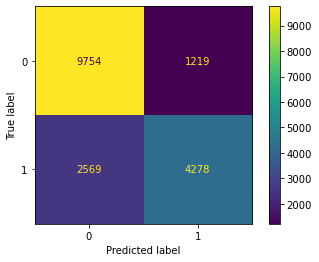

In [14]:
rt.fit(X_train,y_train)
y_pred = rt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [15]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.79      0.89      0.84     10973
non functional       0.78      0.62      0.69      6847

      accuracy                           0.79     17820
     macro avg       0.78      0.76      0.77     17820
  weighted avg       0.79      0.79      0.78     17820



# Checking is overfitting

In [16]:
print(rt.score(X_train,y_train))
print(rt.score(X_test,y_test))

0.7825396825396825
0.7874298540965208


# AUC

In [17]:
from sklearn.metrics import roc_auc_score

y_score = rt.fit(X_train, y_train).predict_proba(X_test)



roc_auc_ovr = roc_auc_score(
    y_test,
    y_score[:, 1],
)
roc_auc_ovr

0.8364179700959101

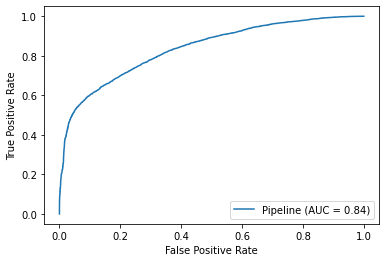

In [18]:
plot_roc_curve(rt,X_train,y_train);

# Random Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV



pipe_grid = {'model__max_depth': [10, 25, 35, None],
             'model__min_samples_leaf': [1, 2, 4],
             'model__min_samples_split': [2, 5, 10],
             'model__n_estimators': [100, 400, 800, 1000]}


cv = RandomizedSearchCV(estimator = rt,
                  param_distributions = pipe_grid, cv = 5, n_iter = 30)

In [20]:
cv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numpipe',
                                                                               Pipeline(steps=[('numnorm',
                                                                                                StandardScaler())]),
                                                                               Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                              ('nominalpipe',
                                                                               Pipeline(steps=[('onehotenc',
                                                                                                OneHotEncoder(handle_unknown='ignore',...
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              RandomForestClassifier(max_depth=5,
                                                                     random_state=42))]),
                   n_iter=30,
                   param_distributions={'model__max_depth': [10, 25, 35, None],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 400, 800,
                                                                1000]})

In [25]:
# cv.fit(X_train, y_train);

In [26]:
cv.best_params_

{'model__n_estimators': 100,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_depth': 25}

In [27]:
cv.best_score_

0.8419913419913418

In [34]:
from joblib import dump, load
dump(cv.best_params_, 'Ran_For_best_params.joblib') 
clf = load('Ran_For_best_params.joblib')

In [39]:
clf

{'model__n_estimators': 100,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_depth': 25}

# Best Model

In [35]:
best_model = cv.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...
                                                  Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=25, min_samples_split=5,
                                        random_state=42))])

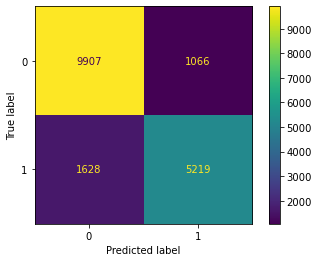

In [36]:
best_model.fit(X_train,y_train)
best_y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

# Best Model Accuracy

In [46]:
print(best_model.score(X_test,y_test))

0.8488215488215488


In [47]:
print(classification_report(y_test, best_y_pred))

                precision    recall  f1-score   support

    functional       0.86      0.90      0.88     10973
non functional       0.83      0.76      0.79      6847

      accuracy                           0.85     17820
     macro avg       0.84      0.83      0.84     17820
  weighted avg       0.85      0.85      0.85     17820



# Best Model AUC

In [37]:
from sklearn.metrics import roc_auc_score

best_y_score = best_model.fit(X_train, y_train).predict_proba(X_test)



roc_auc_ovr = roc_auc_score(
    y_test,
    best_y_score[:, 1],
)
roc_auc_ovr

0.9158600732355109

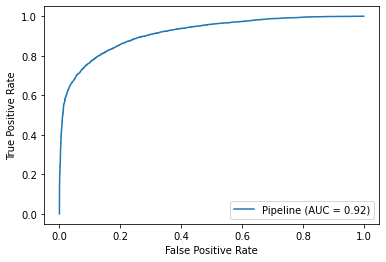

In [48]:
plot_roc_curve(best_model,X_test,y_test);